In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/my_computer/TF_2_Notebooks_and_Data/04-CNNs/Practice/Dog_breed

/content/drive/MyDrive/my_computer/TF_2_Notebooks_and_Data/04-CNNs/Practice/Dog_breed


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms,datasets,models
from torch.utils.data import DataLoader
from collections import OrderedDict

import os
%matplotlib inline

In [ ]:
train_dir = "dogImages/train/"
test_dir = "dogImages/test/"
valid_dir = "dogImages/valid/"

In [ ]:
train_trans = transforms.Compose([transforms.RandomRotation(20),transforms.ToTensor(),
                                 transforms.RandomResizedCrop(400),transforms.RandomHorizontalFlip(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_trans = transforms.Compose([transforms.RandomRotation(20),transforms.ToTensor(),
                                 transforms.RandomResizedCrop(400),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_trans = transforms.Compose([transforms.RandomRotation(20),transforms.ToTensor(),
                                 transforms.RandomResizedCrop(400),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
train_data = datasets.ImageFolder(train_dir,transform=train_trans)
test_data = datasets.ImageFolder(test_dir,transform=test_trans)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_trans)


train_loader = DataLoader(train_data,batch_size=40,shuffle=True)
test_loader = DataLoader(test_data,batch_size=16,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=16,shuffle=True)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
image,label = next(iter(train_loader))

In [ ]:
label

tensor([ 91,  56,  74,  24,  86, 108, 105,  43,  37,  31,  57,  35,  65, 102,
         38,  25,  10,  91,  29, 100,   4,  78,  43,  12,  15,  98, 113,  33,
          0,  33,  72,  78, 114, 126,  24,  16,  66,  13,  34, 131])

In [ ]:
dicte = {}
key = 0
for i in sorted(os.listdir("dogImages/train")):
  dicte[key]=i[4:]
  key+=1

In [ ]:
{str(key):str(value) for key,value in dicte.items()}

In [ ]:
import json
with open('mask.json','r') as f:
  dog_breed = json.load(f)
dog_breed

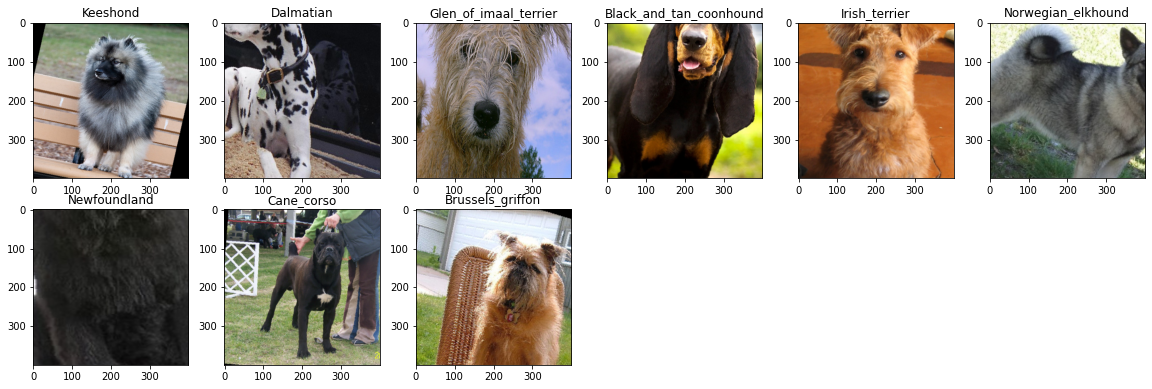

In [ ]:
plt.figure(figsize=(20,20))
for i in range(1,10):
  ax = plt.subplot(6,6,i)
  img = (image[i-1].numpy().transpose(1,2,0)*([0.229, 0.224, 0.225]))+([0.485, 0.456, 0.406])
  img = np.clip(img,0,1)
  ax.imshow(img)
  ax.set_title(([dog_breed[str(j)] for j in range(len(dog_breed)) if str(label[i-1])[7:-1]== str(j)])[0])

In [ ]:
from torch.optim import Adam

# my


In [ ]:
model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for param in model.parameters():
  param.requires_grad = False
model.classifier = torch.nn.Sequential(OrderedDict([("f1",torch.nn.Linear(25088,1024)),
                                                     ("relu1",torch.nn.ReLU()),
                                                     ("dr1",torch.nn.Dropout(.2)),
                                                     ("f2",torch.nn.Linear(1024,512)),
                                                     ("relu2",torch.nn.ReLU()),
                                                     ("dr2",torch.nn.Dropout(.2)), 
                                                     ("f3",torch.nn.Linear(512,133)),
                                                     ("sm",torch.nn.LogSoftmax(dim=1))]))
optimizer = Adam(model.classifier.parameters(),lr=.001)
criterion = torch.nn.NLLLoss()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device);

cuda


In [ ]:
def validation(model,valid_loader):
  test_loss = 0
  accuracy = 0
  total = 0
  correct = 0
  for images,labels in valid_loader:
    images,labels = images.to(device),labels.to(device)
    output = model.forward(images)
    loss = criterion(output,labels)
    _,prediction = torch.max(output,1)
    test_loss += criterion(output,labels).item()
    total += labels.size(0)
    correct +=  (prediction == labels).sum().item()
    accuracy = 100*(correct/total)
  return test_loss,accuracy

In [ ]:
epochs = 100
steps = 0
print_every = 10
training_loss = 0
tr_accuracy = 0
tr_loss = []
ts_loss = []
tr_accu = []
ts_accu = []
step = []
total = 0
correct = 0
for e in range(epochs):
  for imges,labels in train_loader:
    model.train()
    steps += 1
    images,labels = imges.to(device),labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)

    loss = criterion(output,labels)

    loss.backward()
    optimizer.step()

    training_loss += loss.item()

    _,predictions = torch.max(output,1)
    total += labels.size(0)
    correct +=  (predictions == labels).sum().item()
    tr_accuracy = 100*(correct/total)
    if steps % print_every==0:
      model.eval()
      with torch.no_grad():
        test_loss,accuracy = validation(model,valid_loader)
      print("Epochs:{}/{}".format(e+1,epochs),"Training_loss:{:.3f}".format(training_loss/print_every),
            "Train_accu:{:.3f}".format(tr_accuracy),
            "Test_loss:{:.3f}".format(test_loss/len(valid_loader)),"Accuracy:{:.3f}".format(accuracy))
      tr_loss.append(training_loss/print_every)
      ts_loss.append(test_loss/len(valid_loader))
      tr_accu.append(tr_accuracy)
      ts_accu.append(accuracy)
      step.append(steps)
      training_loss = 0

      if accuracy >95:
        break
      else:
        continue

Epochs:1/100 Training_loss:5.163 Train_accu:1.750 Test_loss:4.843 Accuracy:3.832
Epochs:1/100 Training_loss:4.749 Train_accu:3.500 Test_loss:4.685 Accuracy:5.629
Epochs:1/100 Training_loss:4.603 Train_accu:4.500 Test_loss:4.356 Accuracy:10.539
Epochs:1/100 Training_loss:4.330 Train_accu:5.125 Test_loss:4.002 Accuracy:13.413
Epochs:1/100 Training_loss:3.952 Train_accu:6.500 Test_loss:3.657 Accuracy:18.563
Epochs:1/100 Training_loss:3.618 Train_accu:8.083 Test_loss:3.222 Accuracy:24.671
Epochs:1/100 Training_loss:3.282 Train_accu:9.571 Test_loss:3.006 Accuracy:24.671
Epochs:1/100 Training_loss:3.363 Train_accu:10.500 Test_loss:2.922 Accuracy:25.988
Epochs:1/100 Training_loss:3.099 Train_accu:12.194 Test_loss:2.686 Accuracy:31.497
Epochs:1/100 Training_loss:2.808 Train_accu:13.675 Test_loss:2.545 Accuracy:33.174
Epochs:1/100 Training_loss:2.801 Train_accu:15.000 Test_loss:2.408 Accuracy:34.611
Epochs:1/100 Training_loss:2.730 Train_accu:16.042 Test_loss:2.395 Accuracy:35.928
Epochs:1/100 

KeyboardInterrupt: ignored

In [ ]:
model.class_to_idx = train_data.class_to_idx
model.class_to_idx

In [ ]:
torch.save({"model":model.state_dict(),"arch":"vgg16","class_to_idx":model.class_to_idx},"dog_breed.pth")

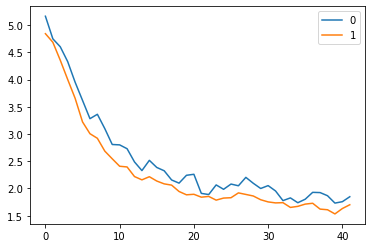

In [ ]:
pd.DataFrame([tr_loss,ts_loss]).T.plot()

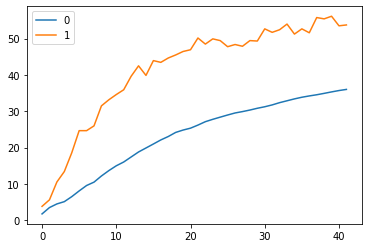

In [ ]:
pd.DataFrame([tr_accu,ts_accu]).T.plot()

In [ ]:
load_model = torch.load("dog_breed.pth") # ,map_location=torch.device('cpu')
model.class_to_idx= load_model["class_to_idx"]
model.load_state_dict(load_model["model"])
model.to(device)

In [ ]:
model.eval()
def Accuracy(model,validloader):
  with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in validloader:
      images, labels = images.to(device),labels.to(device)
      output = model.forward(images)
      ps = torch.exp(output)
      _, predicted = torch.max(output,1)
      total += labels.size(0)
      correct +=  (predicted == labels).sum().item()
    print("Validation Accuracy:{:.1f}%".format((correct*100)/total))

In [ ]:
Accuracy(model,valid_loader)

Validation Accuracy:54.4%


In [ ]:
import PIL.Image as I

In [ ]:
def processand_show(image_path):
  img = I.open(image_path)
  transform = transforms.Compose([transforms.RandomRotation(20),transforms.ToTensor(),
                                  transforms.CenterCrop(400),transforms.RandomHorizontalFlip(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  process_img = transform(img).float()
  show_img = process_img.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406]
  show_img = np.clip(show_img,0,1)
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.imshow(img)
  plt.title("Orignal")
  plt.subplot(2,2,2)
  plt.imshow(show_img)
  plt.title("Transform")
  return process_img

In [ ]:
image_path = "dogImages/test/013.Australian_terrier/Australian_terrier_00923.jpg"

In [ ]:
def final(image_path):
  tensor = processand_show(image_path)
  input = tensor.reshape(1,3,400,400).to(device)
  with torch.no_grad():
    output = model.forward(input)

  probs,indices = torch.exp(output).topk(5)
  probs = np.squeeze(probs.cpu().numpy())
  indices = np.squeeze(indices.cpu().numpy())
  fr_name = [dog_breed[str(x)] for x in indices]
  plt.figure(figsize=(10,10))
  ax2 = plt.subplot(223)
  y_ticks = np.arange(5)
  ax2.set_yticks(y_ticks)
  ax2.barh(y_ticks,probs, align = 'center')
  ax2.set_yticklabels(fr_name);
  print(indices)

[ 12 106 132 110 126]


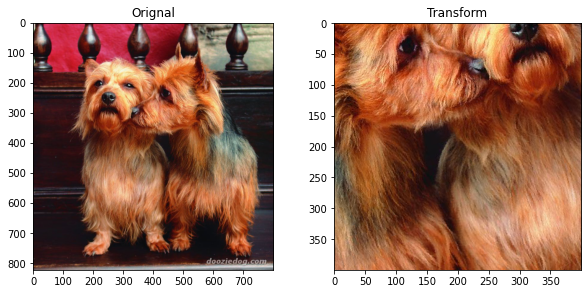

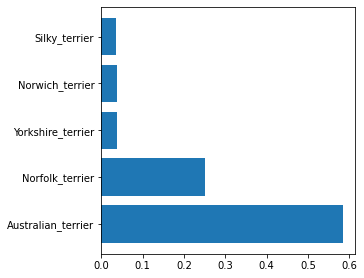

In [ ]:
final(image_path)